# Galaxy Properties and Dark Matter Halo
***

The goal of this project is to predict galaxy properties from the properties of the dark matter haloes in which they form. As dark matter haloes cannot be directly observed, this connection is difficult to determine observationally, but can be derived with empirical models. The catalogues below for 10 different redshifts contain different halo properties (e.g. halo mass, peak mass through time, growth rate) that should be used as features, and galaxy properties (e.g. stellar mass and star formation rate) that should be used as labels. They are in the HDF5 format that can be read in python with the h5py or the pandas packages. The following non-exhaustive list contains suggested steps and ideas to achieve reasonable results.<br>
1. Load the table and divide between features and labels
2. Check which features correlate best with the labels
3. Scale the features (depending on the ML algorithms to between 0 and 1)
4. Split the data in training, validation, and test sets
5. Test different ML algorithms. You should use at least 3 commonly used methods, e.g. random forests, SGD, SVM, neural networks
6. Think about feature importance (using random forests)
7. Think about regularization
8. Think about dimensionality reduction (manifold learning)
9. Plot learning curves - when do you stop?
10. Determine the hyperparameters with the validation set
11. What is the final score on the test set for each algorithm?
***

# 1. Data Preprocessing
***
### 1.1 Reading Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows
pd.set_option("display.max_rows",20)
pd.options.display.max_rows

20

In [3]:
#Reading dataset, Slicing, splitting, and scaling
data_1 = pd.read_hdf("galaxies.Z00.h5").iloc[:,0:9].iloc[:20000, :]
data_1.head()

,Halo_mass,Halo_growth_rate,Halo_mass_peak,Scale_peak_mass,Scale_half_mass,Halo_radius,Concentration,Halo_spin,Stellar_mass
0,11.291506,0.000000,11.933064,0.52,0.26,0.153729,207.948105,0.03063,10.426738
1,11.107182,0.000000,11.269677,0.89,0.49,0.133456,119.950928,0.02274,9.099111
2,10.774375,5.415474,11.231920,0.38,0.30,0.103370,20.775208,0.00583,9.304751
3,9.996202,0.150599,10.529177,0.55,0.47,0.056887,39.662548,0.03998,7.168949
4,9.668787,0.000000,10.674248,0.65,0.26,0.044248,46.062977,0.02509,7.502442


###  1.2 A closer look into the features

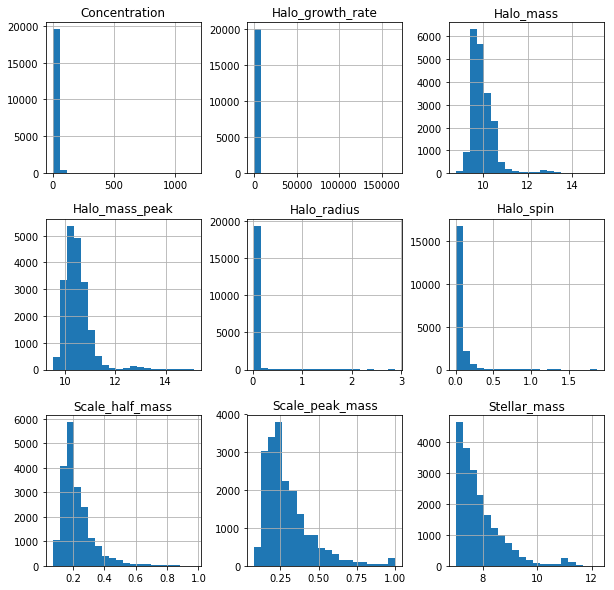

In [4]:
data_1_histograms= data_1.hist(bins=20, figsize=[10,10])

The conclusion that can be drawn from the above histograms is
-  Concentration, Halo_growth_rate, halo_radius, and halo_spin remains approximately constants as stellar mass increase. Hence we expect a small correlation between those features and stellar mass.
-  Consentration, Halo_growth_rate,Halo_radius, halo_spin, scale_peak_mass, and stellar do not follow (approximately) Gaussian distribution, therefore for feature scalling, we will use min-max scaler.
-  Halo_mass, halo_mass_peak and scale_half_mass approximately are distributed according to Gaussian, hence we will use standard scaler for feature scaling
***

### 1.3 Correlation between Feature and Labels

In [5]:
corr_matrix = data_1.corr()
corr_matrix.iloc[:, 8].sort_values()

Halo_spin          -0.159894
Halo_growth_rate    0.108067
Concentration       0.158072
Scale_half_mass     0.316507
Scale_peak_mass     0.367370
Halo_radius         0.614438
Halo_mass           0.758103
Halo_mass_peak      0.848301
Stellar_mass        1.000000
Name: Stellar_mass, dtype: float64

### 1.4 Preprocessing Pipeline

In [6]:
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

#splitting feature and label
dataset_1=data_1.copy()
X=dataset_1.drop(["Stellar_mass"], axis=1)
y= dataset_1["Stellar_mass"]

#splitting test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#define a custom transformer class for feature scaling 
class FeatureSelector(TransformerMixin, BaseEstimator):
    def __init__(self, feature_list):
        self.feature_list = feature_list
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_list].values


minmax_feature=["Concentration", "Halo_growth_rate","Halo_radius", "Halo_spin", "Scale_peak_mass" ]
st_feature= ["Halo_mass", "Halo_mass_peak", "Scale_half_mass"] 

#minmax scaling pipleline
minmax_steps= [("mm_selector", FeatureSelector(minmax_feature)),
               ("imputer", Imputer(strategy= "mean")), ("mm_scaler", MinMaxScaler())]
minmax_pipe= Pipeline(minmax_steps)

#standard scaling pipeline
st_steps =  [("st_selector", FeatureSelector(st_feature)),
             ("imputer", Imputer(strategy= "mean")), ("st_scaler", StandardScaler())]
st_pipe=Pipeline(st_steps)

#combined pipeline to concateante output of the above two pipeline
prep_pipe=FeatureUnion([("minmax", minmax_pipe), ("st", st_pipe)])

/home/khoirul_muzakka/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


***

# 2. Regression problem using Random Forest, SVM, SGD
***
### 2.1 Model Selection using cross-validation


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

#RF Regression
RF_steps=[("prep", prep_pipe), ("RF", RandomForestRegressor())]
RF_regressor=Pipeline(RF_steps)

CV_score=cross_val_score(RF_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
display_scores(CV_score)

/home/khoirul_muzakka/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Scores: [-0.04610724 -0.05051842 -0.04915447 -0.04904733 -0.04606965]
Mean: -0.04817942157959428
Standard Deviation: 0.001784374254299065


In [8]:
#SV Regression
SV_steps=[("prep", prep_pipe), ("SV", SVR())]
SV_regressor=Pipeline(SV_steps)

CV_score=cross_val_score(SV_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
display_scores(CV_score)

Scores: [-0.05937463 -0.06165279 -0.06029826 -0.06255869 -0.0555154 ]
Mean: -0.059879954372940844
Standard Deviation: 0.002441236537711


In [9]:
import warnings
warnings.filterwarnings('ignore')

#SGD Regression
SGD_steps=[("prep", prep_pipe), ("SV", SGDRegressor())]
SGD_regressor=Pipeline(SGD_steps)

CV_score=cross_val_score(SGD_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
display_scores(CV_score)

Scores: [-0.17232846 -0.19220444 -0.18146058 -0.18300164 -0.17805485]
Mean: -0.18140999359102544
Standard Deviation: 0.006523604955418437


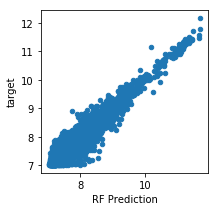

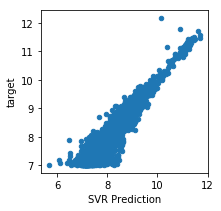

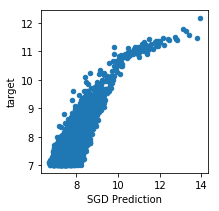

In [10]:
warnings.filterwarnings('ignore')

RF_regressor.fit(X_train, y_train)
SV_regressor.fit(X_train, y_train)
SGD_regressor.fit(X_train, y_train)
report = pd.DataFrame({ "target": y_test, "RF Prediction":RF_regressor.predict(X_test), 
                      "SVR Prediction": SV_regressor.predict(X_test), 
                      "SGD Prediction": SGD_regressor.predict(X_test)})

report.plot.scatter(x="RF Prediction", 
                        y = "target", figsize=[3,3])
report.plot.scatter(x="SVR Prediction", 
                y = "target", figsize=[3,3])
report.plot.scatter(x="SGD Prediction", 
                         y = "target", figsize=[3,3])

Since from CV score suggests that Random forest is the best among the three, we will focus on Random forest from now.
***

### 2.2 Random Forest : Hyperparameter search using Cross-validation

In [11]:
from sklearn.model_selection import GridSearchCV
pg = [{"RF__max_depth": range(1,30)}]
GSCV=GridSearchCV(RF_regressor, pg, scoring = 'neg_mean_absolute_error')
GSCV.fit(X_train, y_train)
print(f"Best Max_dept : {GSCV.best_params_}")

Best Max_dept : {'RF__max_depth': 12}


### 2.3 Random Forest : Learning Curve on the Test Set and compare with Gridsearch

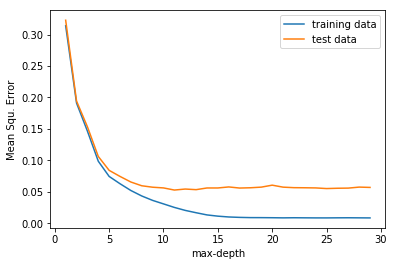

minimum of MSE_test : 0.05270041805912637
minimum of MSE_train : 0.008352218369343604
MSE_test for default value : 0.05802032538599483
MSE_test for default value : 0.008267570654611544


In [12]:
X_prep=prep_pipe.fit_transform(X_train, y_train)
RF_max_dept=range(1,30)
MSE_train=[]
MSE_test=[]
for i in range(1,30):
    forest_reg=RandomForestRegressor(max_depth=i)
    forest_reg.fit(X_prep, y_train) 
    
    MSE_test.append(np.mean((forest_reg.predict(prep_pipe.fit_transform(X_test))-y_test)**2))    
    MSE_train.append(np.mean((forest_reg.predict(X_prep)-y_train)**2))
    
plt.plot(RF_max_dept, MSE_train, label='training data')
plt.plot(RF_max_dept, MSE_test, label='test data')
plt.legend()
plt.xlabel('max-depth')
plt.ylabel('Mean Squ. Error')
plt.show()

forest_reg=RandomForestRegressor()
forest_reg.fit(X_prep, y_train) 
    
MSE_test_0=np.mean((forest_reg.predict(prep_pipe.fit_transform(X_test))-y_test)**2) 
MSE_train_0=np.mean((forest_reg.predict(X_prep)-y_train)**2)
print(f"minimum of MSE_test : {min(MSE_test)}")
print(f"minimum of MSE_train : {min(MSE_train)}")
print(f"MSE_test for default value : {MSE_test_0}")
print(f"MSE_test for default value : {MSE_train_0}")

### 2.4. Random Forest : Final Evaluation on the Test Set
We choose random forest with best paramter given by gridsearch

In [13]:
RF_steps=[("prep", prep_pipe), ("RF", RandomForestRegressor(max_depth=13))]
RF_regressor_13=Pipeline(RF_steps)
RF_regressor_13.fit(X_train, y_train)
report_RF= pd.DataFrame({ "target": y_test, "RF Prediction":RF_regressor_13.predict(X_test)})
print(f"MSE is : {np.mean((RF_regressor.predict(X_test)-y_test)**2)}")
report_RF.head()

MSE is : 0.049405001876952015


,target,RF Prediction
19134,7.238688,7.318531
4981,7.735857,7.764981
16643,7.497379,7.480930
19117,7.328487,7.122101
5306,7.121845,7.124358


***

# 3. Regression with Neural Network
***


### 3.1 Is MLP better than RF, SVM, and SGD?

In [14]:
from sklearn.neural_network import MLPRegressor

MLP_steps=[("prep", prep_pipe), ("MLP", MLPRegressor(hidden_layer_sizes=(6,5,)))]
MLP_regressor=Pipeline(MLP_steps)
CV_MLP_score=cross_val_score(MLP_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
display_scores(CV_MLP_score)


Scores: [-0.0702481  -0.07027606 -0.0790737  -0.0900264  -0.07810145]
Mean: -0.07754514033034683
Standard Deviation: 0.007273431427737025


As can be seen from this result, Neural network is not better than those three. 
***
### 3.2 Gridsearch to obtain the best number of hidden units

In [15]:
pg_MLP= [{"MLP__hidden_layer_sizes": [(6, 5,), (6, 4,), (6,3,),(6,2,), (5,4,),(5,3,), (5,2,), (4,6,)]  } ]

GSCV_MLP=GridSearchCV(MLP_regressor, pg_MLP, scoring = 'neg_mean_absolute_error')
GSCV_MLP.fit(X_train, y_train)
print(f"Best Max_dept : {GSCV_MLP.best_params_}")

Best Max_dept : {'MLP__hidden_layer_sizes': (6, 5)}


### 3.3 Learning curve : Regularization

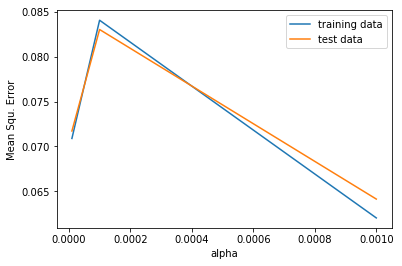

In [16]:
alpha=[0.00001, 0.0001, 0.001]
MSE_train=[]
MSE_test=[]
for i in alpha:
    MLP_reg=MLPRegressor(hidden_layer_sizes=(6,5,), alpha=i)
    MLP_reg.fit(X_prep, y_train) 
    
    MSE_test.append(np.mean((MLP_reg.predict(prep_pipe.fit_transform(X_test))-y_test)**2))    
    MSE_train.append(np.mean((MLP_reg.predict(X_prep)-y_train)**2))
    
plt.plot(alpha, MSE_train, label='training data')
plt.plot(alpha, MSE_test, label='test data')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('Mean Squ. Error')
plt.show()

# 4. Feature Importance and Selection and Dimensionality Reduction
***
### 4.1 Feature Selection based on Feature Importance Score using Random Forest

In [17]:
forest=RandomForestRegressor(max_depth=13)
forest.fit(X_prep, y_train)
FI = pd.DataFrame({"Feature": np.array(X.columns), "Imp Score": np.array(forest.feature_importances_) })
FI

,Feature,Imp Score
0,Halo_mass,0.008864
1,Halo_growth_rate,0.000174
2,Halo_mass_peak,0.011378
3,Scale_peak_mass,0.007409
4,Scale_half_mass,0.124815
5,Halo_radius,0.007461
6,Concentration,0.818845
7,Halo_spin,0.021053


From the above table, one can see that scale_half_mass, concentration, and Halo_spin are the most important feature.
***

In [19]:
IF=["Scale_half_mass", "Concentration"]
X_FI = X[IF]
X_FI_train, X_FI_test, y_train, y_test=train_test_split(X_FI, y, test_size=0.2)

minmax_feature_IF=["Concentration"]
st_feature_IF= ["Scale_half_mass"] 

#minmax scaling pipleline
minmax_steps_IF= [("mm_selector", FeatureSelector(minmax_feature_IF)),
               ("imputer", Imputer(strategy= "mean")), ("mm_scaler", MinMaxScaler())]
minmax_pipe_IF= Pipeline(minmax_steps_IF)

#standard scaling pipeline
st_steps_IF=  [("st_selector", FeatureSelector(st_feature_IF)),
             ("imputer", Imputer(strategy= "mean")), ("st_scaler", StandardScaler())]
st_pipe_IF=Pipeline(st_steps_IF)

#combined pipeline to concateante output of the above two pipeline
prep_pipe_IF=FeatureUnion([("minmax", minmax_pipe_IF), ("st", st_pipe_IF)])
#pipeline for RF regression
RF_steps_IF=[("prep", prep_pipe_IF), ("RF", RandomForestRegressor())]
RF_regressor_IF=Pipeline(RF_steps_IF)

CV_score_IF=cross_val_score(RF_regressor_IF, X_FI, y, cv=5, scoring="neg_mean_squared_error")
display_scores(CV_score_IF)

Scores: [-0.78700893 -0.70588082 -0.72381917 -0.88758947 -1.15718222]
Mean: -0.8522961196648431
Standard Deviation: 0.16517102519248394


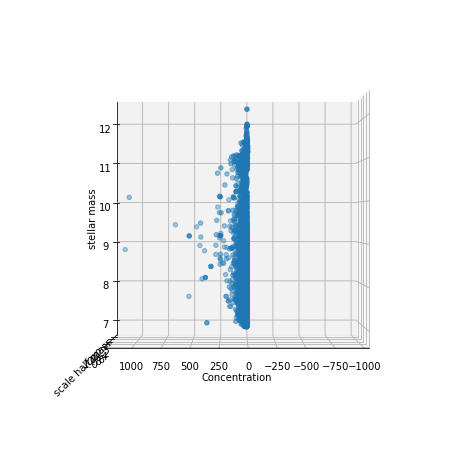

In [21]:
%matplotlib inline
from mpl_toolkits import mplot3d
fig=plt.figure(figsize=[8,8])
ax=plt.axes(projection='3d', )
zline = y
xline = X_FI[["Concentration"]]
yline = X_FI[["Scale_half_mass"]]
ax.scatter3D(xline, yline, zline)
ax.set_xlabel("Concentration")
ax.set_ylabel("scale half mass")
ax.set_zlabel("stellar mass")
ax.set_xbound([-1000, 1200])
ax.view_init(0,90)

### 4.2 PCA

In [22]:
from sklearn.decomposition import PCA
#data preprocessing+pca pipeline


prep_with_pca_step=[("prep_pipe",FeatureUnion([("minmax", minmax_pipe), ("st", st_pipe)])),
                    ("pca", PCA(n_components=2))]
prep_pca=Pipeline(prep_with_pca_step)
X_PCA=prep_pca.fit_transform(X)

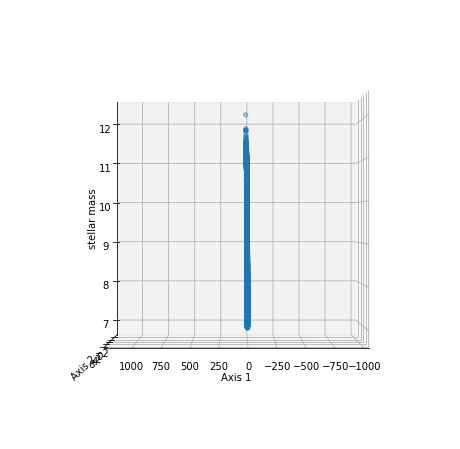

In [23]:
%matplotlib inline

fig=plt.figure(figsize=[8,8])
ax=plt.axes(projection='3d', )
zline = y
xline = X_PCA[:, 0]
yline = X_PCA[:, 1]
ax.scatter3D(xline, yline, zline)
ax.set_xlabel("Axis 1")
ax.set_ylabel("Axis 2")
ax.set_zlabel("stellar mass")
ax.set_xbound([-1000, 1200])
ax.view_init(0,90)

In [24]:
#pipeline for RF regression with PCA
PCARF_steps=[("prep_pipe",FeatureUnion([("minmax", minmax_pipe), ("st", st_pipe)])),
                    ("pca", PCA(n_components=2)),("RF", RandomForestRegressor()) ]
RF_regressor_PCA=Pipeline(PCARF_steps)

CV_score_PCA=cross_val_score(RF_regressor_PCA, X, y, cv=5, scoring="neg_mean_squared_error")
display_scores(CV_score_PCA)

Scores: [-0.22710181 -0.20325486 -0.21110799 -0.17875839 -0.35620212]
Mean: -0.2352850345988708
Standard Deviation: 0.06243977864089231


### 4.3 Manifold Learning : Local Linear Embedding

In [25]:
from sklearn.manifold import LocallyLinearEmbedding as LLA

prep_with_LLA_step=[("prep_pipe",FeatureUnion([("minmax", minmax_pipe), ("st", st_pipe)])),
                    ("lla", LLA(n_components=2))]
prep_LLA=Pipeline(prep_with_LLA_step)
X_LLA=prep_LLA.fit_transform(X)

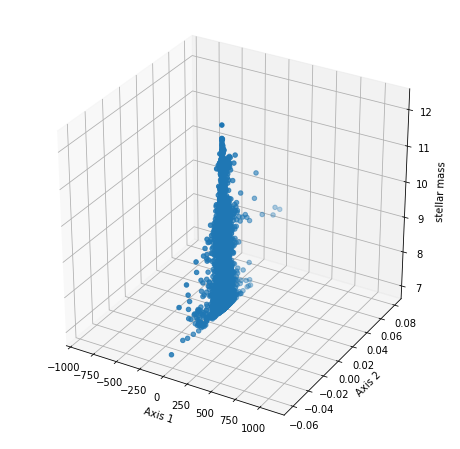

In [28]:
%matplotlib inline

fig=plt.figure(figsize=[8,8])
ax=plt.axes(projection='3d', )
zline = y
xline = X_LLA[:, 0]
yline = X_LLA[:, 1]
ax.scatter3D(xline, yline, zline)
ax.set_xlabel("Axis 1")
ax.set_ylabel("Axis 2")
ax.set_zlabel("stellar mass")
ax.set_xbound([-1000, 1200])
ax.view_init()

In [29]:
#pipeline for RF regression with LLA
LLARF_steps=[("prep_pipe",FeatureUnion([("minmax", minmax_pipe), ("st", st_pipe)])),
                    ("lla", LLA(n_components=2)),("RF", RandomForestRegressor()) ]
RF_regressor_LLA=Pipeline(LLARF_steps)

CV_score_LLA=cross_val_score(RF_regressor_LLA, X, y, cv=5, scoring="neg_mean_squared_error")
display_scores(CV_score_LLA)

Scores: [-0.58705178 -0.42328337 -0.53149862 -0.55793961 -0.56459704]
Mean: -0.5328740827555425
Standard Deviation: 0.05758795902412199
